# **MODEL TRAINING & SELECTION NOTEBOOK**

In [55]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

### **Load Data**

In [56]:
X_train = pd.read_csv('../data/Train-Test/X_train.csv')
y_train = pd.read_csv('../data/Train-Test/y_train.csv')
X_test = pd.read_csv('../data/Train-Test/X_test.csv')
y_test = pd.read_csv('../data/Train-Test/y_test.csv')

In [57]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    metrics = {
        'Train RMSE': np.sqrt(mean_squared_error(y_train, y_pred_train)),
        'Test RMSE': np.sqrt(mean_squared_error(y_test, y_pred_test)),
        'Train MAE': mean_absolute_error(y_train, y_pred_train),
        'Test MAE': mean_absolute_error(y_test, y_pred_test),
        'Train R2': r2_score(y_train, y_pred_train),
        'Test R2': r2_score(y_test, y_pred_test)
    }
    
    return metrics

### **Linear Regression**

In [58]:
X_train.select_dtypes(include='object').columns


Index([], dtype='object')

In [59]:
X_train.dtypes.value_counts()

int64      16
float64     9
Name: count, dtype: int64

In [60]:
X_train.isnull().sum()


fiscalQuarter                           0
productionDept_Stitching Unit           0
productionDept_ Finishing & Quality     0
productionDept_Finishing & Quality      0
dayOfWeek_Tuesday                       0
dayOfWeek_Monday                        0
dayOfWeek_Sunday                        0
dayOfWeek_Thursday                      0
dayOfWeek_Saturday                      0
dayOfWeek_Wednesday                     0
plannedEfficiency                       0
standardMinuteValue                     0
workInProgress                          0
overtimeMinutes                         0
performanceBonus                        0
idleWorkers                             0
styleChangeCount                        0
workerCount                             0
idleOccurred                            0
month                                   0
dayOfMonth                              0
weekOfYear                              0
dayOfYear                               0
workPerWorker                     

In [61]:
X_train['styleChangeCount'].fillna(X_train['styleChangeCount'].mode()[0], inplace=True)
X_test['styleChangeCount'].fillna(X_train['styleChangeCount'].mode()[0], inplace=True)

C:\Users\harsh\AppData\Local\Temp\ipykernel_13328\2559394880.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_train['styleChangeCount'].fillna(X_train['styleChangeCount'].mode()[0], inplace=True)
C:\Users\harsh\AppData\Local\Temp\ipykernel_13328\2559394880.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting va

In [62]:
lr = LinearRegression()
lr.fit(X_train, y_train)

lr_metrics = evaluate_model(lr, X_train, y_train, X_test, y_test)
print("Linear Regression Performance:\n", lr_metrics)

Linear Regression Performance:
 {'Train RMSE': np.float64(0.14725981073102146), 'Test RMSE': np.float64(0.14153248065637547), 'Train MAE': 0.10703810456583362, 'Test MAE': 0.10267653299607175, 'Train R2': 0.2955064071906871, 'Test R2': 0.30208572831275327}


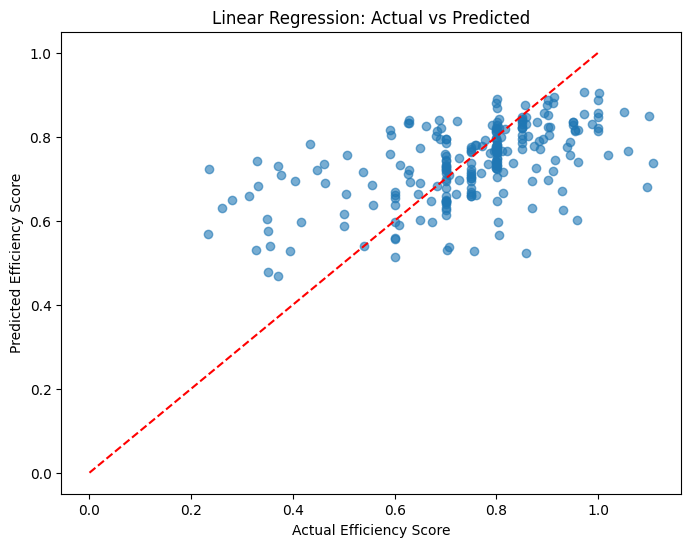

In [63]:
plt.figure(figsize=(8,6))
plt.scatter(y_test, lr.predict(X_test), alpha=0.6)
plt.xlabel("Actual Efficiency Score")
plt.ylabel("Predicted Efficiency Score")
plt.title("Linear Regression: Actual vs Predicted")
plt.plot([0,1],[0,1], color='red', linestyle='--')
plt.show()


### **Random Forest Regressor**

In [64]:
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

In [75]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False],
    'min_samples_split': [2, 5, 10]
}

In [76]:
rf_random = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_distributions=param_grid, 
    n_iter=20,
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1,
    scoring='r2'
)

rf_random.fit(X_train, y_train)
print("Best parameters:", rf_random.best_params_)

best_rf = rf_random.best_estimator_

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': False}


In [77]:
best_rf = RandomForestRegressor(
    n_estimators=200,
    min_samples_split=5,
    min_samples_leaf=1,
    max_features=0.5,
    max_depth=None,
    random_state=42
)

best_rf.fit(X_train, y_train)


,n_estimators,200
,criterion,'squared_error'
,max_depth,None
,min_samples_split,5
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,0.5
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [78]:
def evaluate_rf_model(model, X_train, y_train, X_test, y_test):
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    

    rf_metrics = {
        'Train RMSE': np.sqrt(mean_squared_error(y_train, y_pred_train)),
        'Test RMSE': np.sqrt(mean_squared_error(y_test, y_pred_test)),
        'Train MAE': mean_absolute_error(y_train, y_pred_train),
        'Test MAE': mean_absolute_error(y_test, y_pred_test),
        'Train R2': r2_score(y_train, y_pred_train),
        'Test R2': r2_score(y_test, y_pred_test)
    }
    
    return rf_metrics

In [79]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
y_pred = best_rf.predict(X_test)

print("R²:", r2_score(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("MAE:", mean_absolute_error(y_test, y_pred))

rf_metrics = evaluate_rf_model(best_rf, X_train, y_train, X_test, y_test)
print("Random Forest Performance:\n", rf_metrics)


R²: 0.44390102110519314
RMSE: 0.12633716520268296
MAE: 0.07412306560979026
Random Forest Performance:
 {'Train RMSE': np.float64(0.06620190496315949), 'Test RMSE': np.float64(0.12633716520268296), 'Train MAE': 0.0401661417249954, 'Test MAE': 0.07412306560979026, 'Train R2': 0.8576198176915643, 'Test R2': 0.44390102110519314}


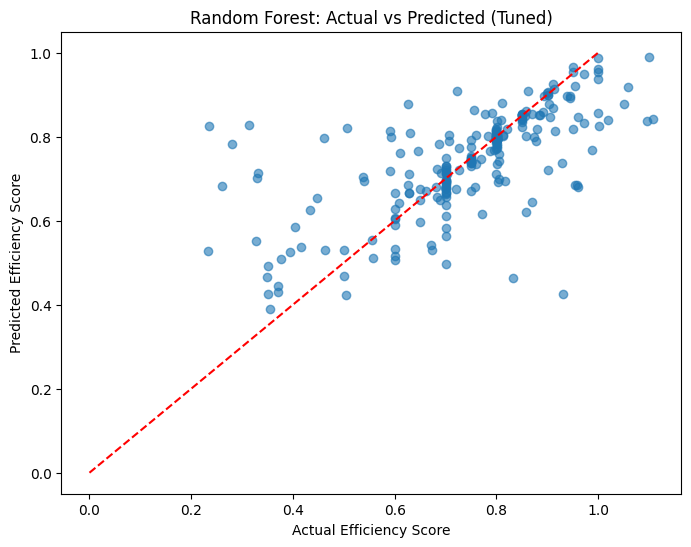

In [80]:
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.xlabel("Actual Efficiency Score")
plt.ylabel("Predicted Efficiency Score")
plt.title("Random Forest: Actual vs Predicted (Tuned)")
plt.plot([0,1],[0,1], color='red', linestyle='--')
plt.show()


### **Feature importance**

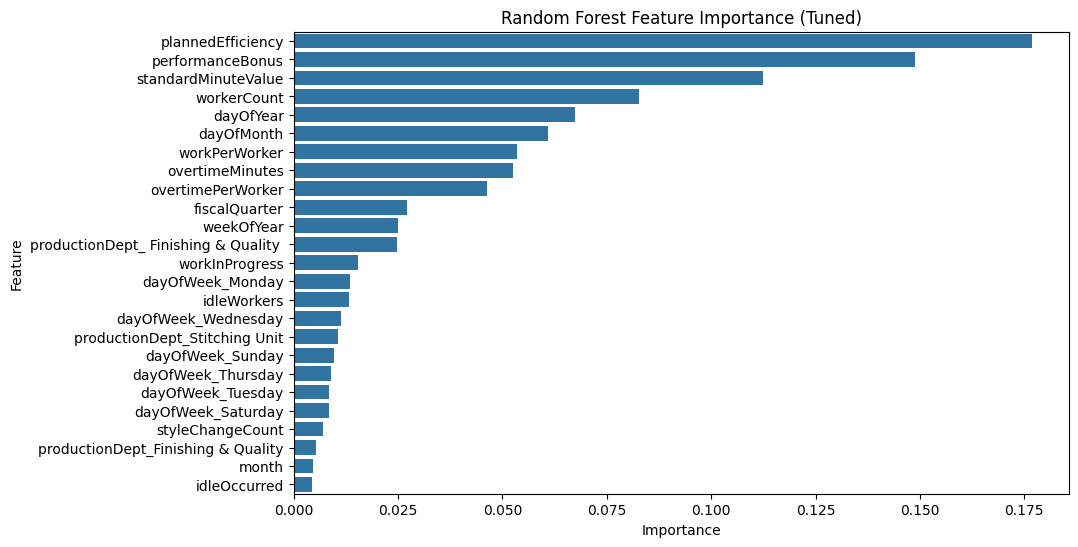

In [81]:
importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': best_rf.feature_importances_})
importances = importances.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=importances)
plt.title("Random Forest Feature Importance (Tuned)")
plt.show()

### **XGBoost Regressor**

In [82]:
xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
xgb.fit(X_train, y_train)

xgb_metrics = evaluate_model(xgb, X_train, y_train, X_test, y_test)
print("XGBoost Performance:\n", xgb_metrics)

XGBoost Performance:
 {'Train RMSE': np.float64(0.07653264903184197), 'Test RMSE': np.float64(0.1309460036076672), 'Train MAE': 0.04594274129167076, 'Test MAE': 0.07795047811555818, 'Train R2': 0.8097160914634627, 'Test R2': 0.40258745355537406}


### **Feature importance**

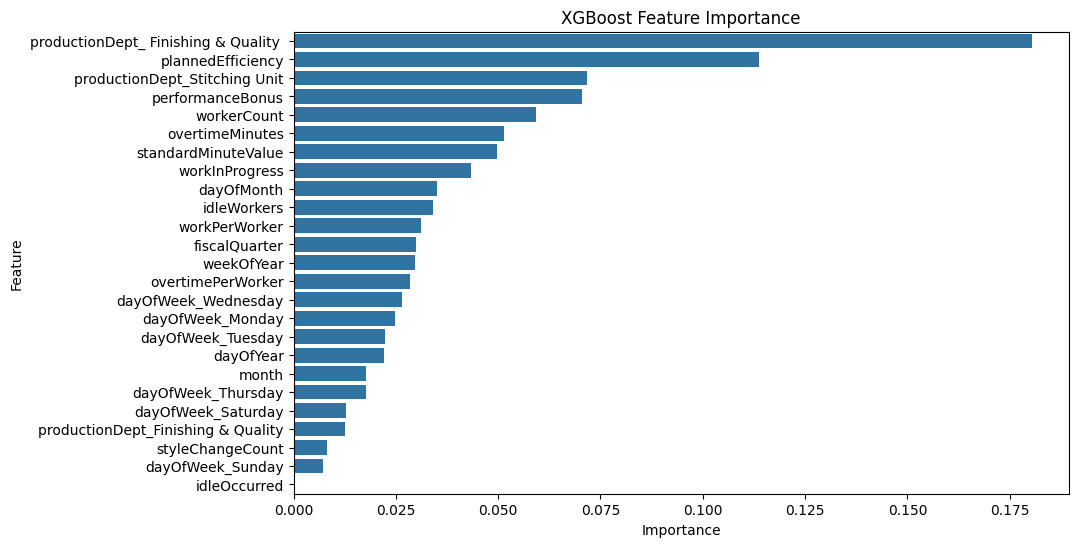

In [83]:
xgb_importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': xgb.feature_importances_})
xgb_importances = xgb_importances.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=xgb_importances)
plt.title("XGBoost Feature Importance")
plt.show()

### **Compare MOdels**

In [84]:
comparison = pd.DataFrame([lr_metrics, rf_metrics, xgb_metrics], index=['LinearRegression','RandomForest','XGBoost'])
comparison

,Train RMSE,Test RMSE,Train MAE,Test MAE,Train R2,Test R2
LinearRegression,0.147260,0.141532,0.107038,0.102677,0.295506,0.302086
RandomForest,0.066202,0.126337,0.040166,0.074123,0.857620,0.443901
XGBoost,0.076533,0.130946,0.045943,0.077950,0.809716,0.402587
